# Biweekly Report 5
## Allison Liu
## APPM 5720

In this notebook, I compare a variety of error metrics on solar magnetogram datasets that I used for training GANs in my own research. For my research, I have been using GANs to solve an Image-to-Image translation problem. In recent weeks, I have been struggling with how to quantify and interpret the results of a few of the GAN models I have trained since it is not particularly straightforward. We learned a lot about evaluating GANs in class, so I wanted to use this biweekly report as an opportunity to combine what I have learned in class with a research project that I have been working on. Hopefully I can gain some more insight into what my trained results actually mean and get a more in-depth understanding of error-metrics used to evaluate GANs along the way. In addition to actually computing the error metrics, much of my time for this report was spent reading and learning about these evaluation metrics which are summarized in this notebook.

Currently I am working with the Laboratory for Atmospheric and Space Physics on improving solar flare prediction, which impacts life on Earth by having the potential to disrupt our power grid and communication systems (satellite, GPS, etc.). For solar flare prediction, there are two solar magnetogram datasets which have been collected by satellites; the Michelson Doppler Imager (MDI) collected data from 1996-2011 and the Helioseismic and Magnetic Imager (HMI), which began collecting data in 2010 and is still operational. For most solar flare prediction models, only HMI magnetograms are used, which halves the amount of data available to be used for training. Due to differences in resolution, field-of-view differences, and rotation of the two datasets, it's nontrivial to create a combined dataset without losing information and without needing to decrease the resolution of future HMI images collected.

I have been experimenting with different types of GANs to see which ones work best to super-resolve the lower-quality MDI images into HMI quality. So far, I have tried Pix2Pix, CycleGAN, and CUT (Contrastive Unpaired Translation). Pix2Pix, described in the paper titled "Image-to-Image Translation with Conditional Adversarial Networks (Isola et al. 2017)", and CycleGAN, described in the paper titled "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks (Zhu et al. 2017)" were both discussed in class. The modifications I made to the original implementations are available on my GitHub: https://github.com/a11isonliu.

Note that this jupyter notebook will not run, since the data I use is stored locally.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.color import rgb2gray
import cv2
import random
import datetime
import pandas as pd


List files in paths to results.

In [2]:
mdi2hmi_cyclegan_results_path = '/Volumes/AllisonLASP/2022/results/mdi2hmi_cycleGAN/test_latest/images/'
mdi2hmi_cut_results_path = '/Volumes/AllisonLASP/2022/results/mdi2hmi_CUT/test_latest/images/'
mdi2hmi_pix2pix_results_path = '/Volumes/AllisonLASP/2022/results/mdi2hmi_pix2pix/test_latest/images/'

mdiprox2hmi_cyclegan_results_path = '/Volumes/AllisonLASP/2022/results/mdiprox2hmi_cycleGAN/test_latest/images/'
mdiprox2hmi_cut_results_path = '/Volumes/AllisonLASP/2022/results/mdiprox2hmi_CUT/test_latest/images/'
mdiprox2hmi_large_results_path = '/Volumes/AllisonLASP/2022/results/mdiprox2hmi_CUT_20220206/test_latest/images/'

def make_file_list(results_path, verbose=True):
    if verbose==True:
        print(f"CURRENT PATH: {results_path}")
    mdi_path = os.path.join(results_path, 'real_A')
    hmi_path = os.path.join(results_path, 'real_B')
    synth_path = os.path.join(results_path, 'fake_B')

    mdi_list = [os.path.join(mdi_path, file) for file in os.listdir(mdi_path)]
    hmi_list = [os.path.join(hmi_path, file) for file in os.listdir(hmi_path)]
    synth_list = [os.path.join(synth_path, file) for file in os.listdir(synth_path)]

    mdi_list.sort()
    hmi_list.sort()
    synth_list.sort()

    return mdi_list, hmi_list, synth_list

mdi_list_cyclegan, hmi_list_cyclegan, syn_list_cyclegan = make_file_list(mdi2hmi_cyclegan_results_path)
mdi_list_cut, hmi_list_cut, syn_list_cut = make_file_list(mdi2hmi_cut_results_path)
mdi_list_pix2pix, hmi_list_pix2pix, syn_list_pix2pix = make_file_list(mdi2hmi_pix2pix_results_path)

CURRENT PATH: /Volumes/AllisonLASP/2022/results/mdi2hmi_cycleGAN/test_latest/images/
CURRENT PATH: /Volumes/AllisonLASP/2022/results/mdi2hmi_CUT/test_latest/images/
CURRENT PATH: /Volumes/AllisonLASP/2022/results/mdi2hmi_pix2pix/test_latest/images/


### Load trained results
Some helper functions.

* load_images(): loads an input, target, and synthetic image taken at a single time (or within a couple minutes of the same time) as .npy files from their paths

* set_bg(): obtains the boundary of the magnetogram and separates it from the background, we have circular images.


In [3]:
def load_images(im_n, mdi_list, hmi_list, synth_list, pretty=0):
    hmi_color =np.load(hmi_list[im_n])
    mdi_color =np.load(mdi_list[im_n])
    syn_color =np.load(synth_list[im_n])
    hmi = set_bg(rgb2gray(hmi_color), pretty=pretty)
    mdi = set_bg(rgb2gray(mdi_color), pretty=pretty)
    syn = set_bg(rgb2gray(syn_color), pretty=pretty)

    mdi_rot = np.rot90(mdi,2)
    syn_rot = np.rot90(syn, 2)

    return hmi, mdi_rot, syn_rot

# This function detects the boundary of the magnetogram and its background, then sets the background to a value
def set_bg(img, pretty):
    thresh = np.ma.masked_equal(img, 0, copy=True).mask.astype(np.uint8) # get thresholded img. If img values != 0, set to 1
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # get contours of thresholded img
    mask_inv = (cv2.drawContours(thresh, contours, 1, (255,255,255), -1)/255).astype(np.uint8) # get mask as 0s and 1s, inside circle = 1, outside circle = 0
    mask = np.where((mask_inv==0)|(mask_inv==1), mask_inv^1, mask_inv) # invert above mask using bitwise or: inside circle = 0, outside circle = 1
    new_img = np.ma.array(img, mask=mask)
    assert pretty==0 or pretty==1 or pretty==2, 'value not valid'
    if pretty == 1:
        new_img = new_img.filled(fill_value=-0.5)
    elif pretty == 0:
        new_img = new_img.filled(fill_value=np.NaN)
    elif pretty == 2:
        new_img = new_img.filled(fill_value=0) 
        
    return new_img


### Plotting Results
Some code used for plotting results. These visuals aren't actually necessary for the error calculations, but I'm including them, because they give relevant context.

In [4]:
# Plot Images
def compare_model_ims(n1, n2):
    mdi_list_cyclegan, hmi_list_cyclegan, syn_list_cyclegan = make_file_list(mdi2hmi_cyclegan_results_path, verbose=False)
    mdi_list_cut, hmi_list_cut, syn_list_cut = make_file_list(mdi2hmi_cut_results_path, verbose=False)
    mdi_list_pix2pix, hmi_list_pix2pix, syn_list_pix2pix = make_file_list(mdi2hmi_pix2pix_results_path, verbose=False)
    
    hmi1, mdi_rot1, syn_cyclegan1 = load_images(n1, mdi_list_cyclegan, hmi_list_cyclegan, syn_list_cyclegan, pretty=1)
    _, _, syn_pix2pix1 = load_images(n1, mdi_list_pix2pix, hmi_list_pix2pix, syn_list_pix2pix, pretty=1)
    _, _, syn_cut1 = load_images(n1, mdi_list_cut, hmi_list_cut, syn_list_cut, pretty=1)

    hmi2, mdi_rot2, syn_cyclegan2 = load_images(n2, mdi_list_cyclegan, hmi_list_cyclegan, syn_list_cyclegan, pretty=1)
    _, _, syn_pix2pix2 = load_images(n2, mdi_list_pix2pix, hmi_list_pix2pix, syn_list_pix2pix, pretty=1)
    _, _, syn_cut2 = load_images(n2, mdi_list_cut, hmi_list_cut, syn_list_cut, pretty=1)
    
    fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = axs.ravel()
    
    ax1.imshow(mdi_rot1, cmap="afmhot")
    ax1.set_title("MDI", fontsize=24)
    ax1.axis('off')
    ax2.imshow(syn_pix2pix1, cmap="afmhot")
    ax2.set_title("Pix2Pix", fontsize=24)
    ax2.axis('off')
    ax3.imshow(syn_cyclegan1, cmap="afmhot")
    ax3.set_title("CycleGAN", fontsize=24)
    ax3.axis('off')
    ax4.imshow(syn_cut1, cmap="afmhot")
    ax4.set_title("CUT", fontsize=24)
    ax4.axis('off')
    ax5.imshow(hmi1, cmap="afmhot")
    ax5.set_title("HMI", fontsize=24)
    ax5.axis('off')

    ax6.imshow(mdi_rot2, cmap="afmhot")
    ax6.axis('off')
    ax7.imshow(syn_pix2pix2, cmap="afmhot")
    ax7.axis('off')
    ax8.imshow(syn_cyclegan2, cmap="afmhot")
    ax8.axis('off')
    ax9.imshow(syn_cut2, cmap="afmhot")
    ax9.axis('off')
    ax10.imshow(hmi2, cmap="afmhot")
    ax10.axis('off')

    date1 = mdi_list_cyclegan[n1][-19:-4].replace('_', '')
    date2 = mdi_list_cyclegan[n2][-19:-4].replace('_', '')
    # Check if dates are equal
    d1 = datetime.datetime.strptime(date1, '%Y%m%d%H%M%S')
    s1 = d1.strftime('%Y/%m/%d ~%H:%M:%S')
    # print(s1)
    d2 = datetime.datetime.strptime(date2, '%Y%m%d%H%M%S')
    s2 = d2.strftime('%Y/%m/%d ~%H:%M:%S')
    # print(s2)
    plt.annotate(s1, xy=(-4.5, 1.07), xycoords='axes fraction', fontsize='20')
    plt.annotate(s2, xy=(-4.5, -0.17), xycoords='axes fraction', fontsize='20')

    # plt.tight_layout()
    # fig.subplots_adjust(top=1.15)
    # plt.savefig(os.path.join("/Volumes/AllisonData/Data/results/figures/", date+"_cycleGAN.png"))
    plt.show()
def compare_model_imsP(n1, n2):
    mdi_list_cycleganP, hmi_list_cycleganP, syn_list_cycleganP = make_file_list(mdiprox2hmi_cyclegan_results_path, verbose=False)
    mdi_list_cutP, hmi_list_cutP, syn_list_cutP = make_file_list(mdiprox2hmi_cut_results_path, verbose=False)
    mdi_list_largeP, hmi_list_largeP, syn_list_largeP = make_file_list(mdiprox2hmi_large_results_path, verbose=False)
    
    hmi1, mdi_rot1, syn_cyclegan1 = load_images(n1, mdi_list_cycleganP, hmi_list_cycleganP, syn_list_cycleganP, pretty=1)
    _, _, syn_cut1 = load_images(n1, mdi_list_cutP, hmi_list_cutP, syn_list_cutP, pretty=1)
    mdi_rot1 = plot_mdiprox(n1, mdi_list_cycleganP, mdi_list_cyclegan)
    syn_cyclegan1_rot = np.rot90(syn_cyclegan1, 2)
    syn_cut1_rot = np.rot90(syn_cut1, 2)

    hmi2, mdi_rot2, syn_cyclegan2 = load_images(n2, mdi_list_cycleganP, hmi_list_cycleganP, syn_list_cycleganP, pretty=1)
    _, _, syn_cut2 = load_images(n2, mdi_list_cutP, hmi_list_cutP, syn_list_cutP, pretty=1)
    mdi_rot2 = plot_mdiprox(n2, mdi_list_cycleganP, mdi_list_cyclegan)
    syn_cyclegan2_rot = np.rot90(syn_cyclegan2, 2)
    syn_cut2_rot = np.rot90(syn_cut2, 2)
 
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8= axs.ravel()
    
    ax1.imshow(mdi_rot1, cmap="afmhot")
    ax1.set_title("MDI Proxy", fontsize=24)
    ax1.axis('off')
    ax2.imshow(syn_cyclegan1_rot, cmap="afmhot")
    ax2.set_title("CycleGAN", fontsize=24)
    ax2.axis('off')
    ax3.imshow(syn_cut1_rot, cmap="afmhot")
    ax3.set_title("CUT", fontsize=24)
    ax3.axis('off')
    ax4.imshow(hmi1, cmap="afmhot")
    ax4.set_title("HMI", fontsize=24)
    ax4.axis('off')

    ax5.imshow(mdi_rot2, cmap="afmhot")
    ax5.axis('off')
    ax6.imshow(syn_cyclegan2_rot, cmap="afmhot")
    ax6.axis('off')
    ax7.imshow(syn_cut2_rot, cmap="afmhot")
    ax7.axis('off')
    ax8.imshow(hmi2, cmap="afmhot")
    ax8.axis('off')


    # fig.suptitle("CycleGAN", fontsize="16")
    # plt.figtext(0.45, 0.85, "Pix2Pix GAN", verticalalignment='center')
    date1 = mdi_list_cycleganP[n1][-19:-4].replace('_', '')
    date2 = mdi_list_cycleganP[n2][-19:-4].replace('_', '')
    # Check if dates are equal
    d1 = datetime.datetime.strptime(date1, '%Y%m%d%H%M%S')
    s1 = d1.strftime('%Y/%m/%d ~%H:%M:%S')
    # print(s1)
    d2 = datetime.datetime.strptime(date2, '%Y%m%d%H%M%S')
    s2 = d2.strftime('%Y/%m/%d ~%H:%M:%S')
    # print(s2)
    plt.annotate(s1, xy=(-3.3, 1.07), xycoords='axes fraction', fontsize='20')
    plt.annotate(s2, xy=(-3.3, -0.17), xycoords='axes fraction', fontsize='20')

    # plt.tight_layout()
    # fig.subplots_adjust(top=1.15)
    # plt.savefig(os.path.join("/Volumes/AllisonData/Data/results/figures/", date+"_cycleGAN.png"))
    plt.show()
def plot_mdiprox(n, img_list, mdi_im_list, pretty=1):
    im = np.load(img_list[n])
    mdi_im = np.load(mdi_im_list[0])
    im_gray = rgb2gray(im)
    mdi_im_gray = rgb2gray(mdi_im)
    thresh = np.ma.masked_equal(mdi_im_gray, 0, copy=True).mask.astype(np.uint8) # get thresholded img. If img values != 0, set to 1
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # get contours of thresholded img
    mask_inv = (cv2.drawContours(thresh, contours, 1, (255,255,255), -1)/255).astype(np.uint8) # get mask as 0s and 1s, inside circle = 1, outside circle = 0
    mask = np.where((mask_inv==0)|(mask_inv==1), mask_inv^1, mask_inv) # invert above mask using bitwise or: inside circle = 0, outside circle = 1
    new_img = np.ma.array(im_gray, mask=mask)
    
    assert pretty==0 or pretty==1 or pretty==2, 'value not valid'
    if pretty == 1:
        new_img = new_img.filled(fill_value=-0.5)
    elif pretty == 0:
        new_img = new_img.filled(fill_value=np.NaN)
    elif pretty == 2:
        new_img = new_img.filled(fill_value=0)
    # plt.imshow(new_img, cmap='afmhot')
    return new_img

These images show magnetograms, or images of the magnetic field of the sun. The bright patches visible are active regions, or regions where there is a lot of solar activity.

All 5 of the models shown were trained using a GPU available through LASP. Pix2Pix uses input-output pairs to train, while CycleGAN and CUT train on distributions of entire datasets, as discussed in class.

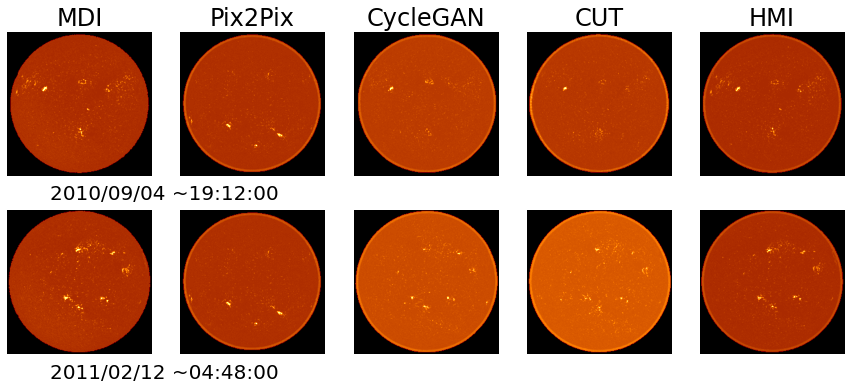

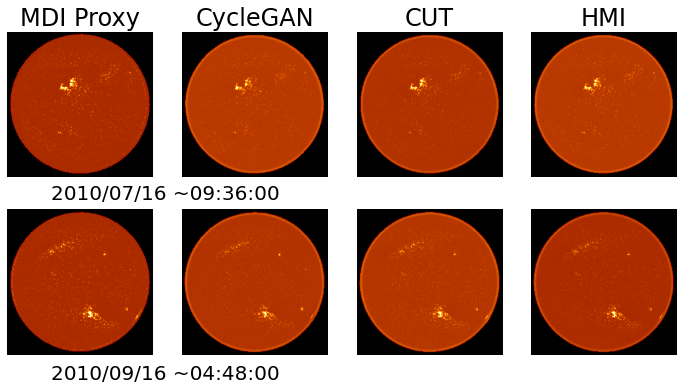

In [5]:
compare_model_ims(19, 170)
compare_model_imsP(70, 214)

The first plot shows a real MDI image on the left and the output HMI image taken at the corresponding time on the right. The generated synthetic images are shown in the columns in between. Each row is an example taken at a different time.

The second plot is the same, but the MDI image is a proxy image downsampled from an HMI image and cropped to achieve a similar field of view as a real MDI image. This was done to create more training pairs for evaluation.

The models were trained on solar magnetograms from April 2010 to April 2011 sampled at 96 minute intervals. The models trained using the MDI dataset was trained on 1038 images and the models trained using downsampled MDI proxy data were trained on 1208 images.

Upon initial visual inspection, we see that CycleGAN and CUT perform well, while Pix2Pix is experiencing mode-collapse. Thus, I only trained the models using MDI Proxy images as inputs using CycleGAN and CUT. CycleGAN exploits the intuitive idea that if you translate from image domain X to image domain Y, translating the image back to domain X from domain Y should yield the original input. CUT is a contrastive learning based framework which aimes to maximize mutual information between patches in input/target datasets.

### Error Calculations
The function error_summary() calculates many error metrics on the target HMI images and the synthetic images generated by the GAN models. I compare to the same error metrics calculated on the target output HMI images and the input MDI images as a baseline.

I first include some very basic error metrics from my own experience and added additional evaluation metrics used for evaluating GANs discussed in class. In addition to computing the error metrics, much of my time for this report was spent reading and learning about these evaluation metrics (mostly the ones often used for GANs, SSIM, FID, IS) rather than getting code to work. Below I give a short summary of each of the evaluation metrics I calculated:
* **Absolute Error:** sum of the absolute valued pixel by pixel difference between target and generated image. Clearly, lower is better, min value of 0
* **Mean Squared Error (MSE):** sum of the squared pixel by pixel difference between target and generated image. Lower is better, min value of 0. RMSE = sqrt(MSE).
* **Peak Signal to Noise Ratio (PSNR):** a ratio between the maximum possible power of a signal and the power of distorting noise, thus higher is better. PSNR is inversely proportional to MSE^2.

Absolute error, MSE, PSNR are all related, so using all three is not particularly telling. Also slight pixel misalignment will cause lots of fluctuation in error. These are naive. 
* **Structural Similarity Index (SSIM):** extracts 3 key features from an image: Luminance, Contrast, and Structure. Value between 0 and 1, 1 indicates perfect structural similarity. Tries to replicate human visual perception system.
    * Luminance: average over pixel values
    * Contrast: standard deviation of pixel values
    * Structure: input signal/its standard deviation

Both FID and IS require access to a pre-trained classifier. 
* **Frechet Inception Distance (FID):** a score calculated by computing the Frechet distance between two Gaussians fitted to feature representations of the Inception network. In other words, it is the difference in embedding of true and synthetic data. Lower is better, min value of 0. FID correlates well with human judgement of visual quality, used to evaluate quality.
I used the default settings, using a dimensionality of 2048 final average pooling features from the pool3 layer of the Inception network. I needed to edit the pytorch-fid implementation slightly to get it to work with my data, repo here:
https://github.com/a11isonliu/pytorch-fid
* **Inception Score (IS):** A good model should generate samples for which, when evaluated by the classifier, the class distribution has low entropy and should also produce diverse samples covering all classes. It has been shown that IS fails to provide useful guidance when comparing models. https://doi.org/10.48550/arXiv.1801.01973 (S. Barratt and R. Sharma 2018)

Evaluation of GAN evaluation metrics:
https://doi.org/10.48550/arXiv.1711.10337 (Lucic et al. 2017)



In [6]:
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio 
# INPUTS: path to output directories from mdi, hmi, synthetic results from a model
def error_summary(results_path, n_images=100, verbose=True):
    # Create file list and sort
    mdi_list, hmi_list, synth_list = make_file_list(results_path, verbose=False)
    mdi_path = os.path.join(results_path, 'real_A')
    if verbose==True:
        print(f'MDI PATH: {mdi_path}')
    file_list = [im for im in os.listdir(mdi_path)]
    file_list.sort()
    abs_err0, abs_err = [], []
    mse0, mse = [], []
    rmse0, rmse = [], []
    psnr0, psnr = [], []
    ssim0, ssim = [], []
    f = []
    im_n = []
    image_index = random.sample(range(0, len(file_list)), n_images)
    for n, im in enumerate(file_list):
        if n in image_index:
            # LOAD FILES
            hmi, mdi_rot, syn_rot = load_images(n, mdi_list, hmi_list, synth_list, pretty=2)
            
            im_n.append(n)
            f.append(im)
            
            # Here we calculate error metric values
            abs_err0.append(abs_error(hmi, mdi_rot)) # hmi vs mdi
            abs_err.append(abs_error(hmi, syn_rot)) # hmi vs synthetic
            mse0.append(mean_squared_error(hmi, mdi_rot))
            mse.append(mean_squared_error(hmi, syn_rot))
            rmse0.append(np.sqrt(mean_squared_error(hmi, mdi_rot)))
            rmse.append(np.sqrt(mean_squared_error(hmi, syn_rot)))
            psnr0.append(peak_signal_noise_ratio(hmi, mdi_rot))
            psnr.append(peak_signal_noise_ratio(hmi, syn_rot))
            ssim0.append(structural_similarity(hmi, mdi_rot))
            ssim.append(structural_similarity(hmi, syn_rot))
    err_df = pd.DataFrame(list(zip(im_n, f, abs_err, mse, rmse, psnr, ssim)), columns=['Image Number', 'file', 'Abs Error', 'MSE', 'RMSE', 'PSNR', 'SSIM'])
    err0_df = pd.DataFrame(list(zip(im_n, f, abs_err0, mse0, rmse0, psnr0, ssim0)), columns=['Image Number', 'file', 'Abs Error', 'MSE', 'RMSE', 'PSNR', 'SSIM'])
    if verbose==True:
        print('##################################')
        print('HMI vs Generated')
        print('##################################')
        print(f'MEAN:\n {err_df.mean()}')
        print('##################################')
        print(f'MEDIAN: \n {err_df.median()}')
        print('##################################')
        print('\n##################################')
        print('HMI vs MDI') 
        print('##################################')
        print(f'MEAN:\n {err0_df.mean()}')
        print('##################################')
        print(f'MEDIAN: \n {err0_df.median()}')
        print('##################################')
    return err_df, err0_df

def abs_error(im1, im2):
    return np.nansum(np.abs(im1-im2))

Calculate error metrics individually for each model.

In [7]:
cyclegan_err_df, cyclegan_err0_df = error_summary(mdi2hmi_cyclegan_results_path, verbose=False)
pix2pix_err_df, pix2pix_err0_df = error_summary(mdi2hmi_pix2pix_results_path, verbose=False)
cut_err_df, cut_err0_df = error_summary(mdi2hmi_cut_results_path, verbose=False)
mdiprox_cyclegan_err_df, mdiprox_cyclegan_err0_df = error_summary(mdiprox2hmi_cyclegan_results_path, verbose=False)
mdiprox_cut_err_df, mdiprox_cut_err0_df= error_summary(mdiprox2hmi_cut_results_path, verbose=False)

In [8]:
hmi_mdi_df = pd.concat([cut_err0_df.mean()[1:6], cyclegan_err0_df.mean()[1:6], pix2pix_err0_df.mean()[1:6]], axis=1, keys=['CUT', 'CycleGAN', 'Pix2Pix'])
hmi_mdi_df.mean(axis=1)

hmi_mdiprox_df = pd.concat([mdiprox_cut_err0_df.mean()[1:6], mdiprox_cyclegan_err0_df.mean()[1:6]], axis=1, keys=['CUT', 'CycleGAN'])

Concatenate results into a complete error summary dataframe.

In [9]:
err_summary_df = pd.concat([pix2pix_err_df.mean()[2:6], cyclegan_err_df.mean()[2:6], cut_err_df.mean()[2:6],  hmi_mdi_df.mean(axis=1)[1:6]], axis=1, keys = ['Pix2Pix','CycleGAN', 'CUT', 'HMI vs MDI'])
fid_row = {'CUT': 18.88019273, 'CycleGAN': 15.86468295, 'Pix2Pix': 45.36619676, 'HMI vs MDI': 126.7485182}
err_summary_df.loc['FID'] = fid_row
err_summary_df

,Pix2Pix,CycleGAN,CUT,HMI vs MDI
MSE,0.001598,0.000801,0.000859,0.001283
RMSE,0.039721,0.027958,0.028836,0.035442
PSNR,28.074482,31.172990,30.954107,29.103446
SSIM,0.830747,0.896611,0.891614,0.772871
FID,45.366197,15.864683,18.880193,126.748518


In [10]:
err_summary_mdiprox_df = pd.concat([mdiprox_cyclegan_err_df.mean()[1:6],mdiprox_cut_err_df.mean()[1:6], hmi_mdiprox_df.mean(axis=1)[0:6]], axis=1, keys = ['CycleGAN', 'CUT', 'HMI vs MDI Proxy'])
fid_row2 = {'CUT': 2.275642109, 'CycleGAN': 5.663433011, 'HMI vs MDI Proxy': 81.72252086}
err_summary_mdiprox_df.loc['FID'] = fid_row2
err_summary_mdiprox_df

,CycleGAN,CUT,HMI vs MDI Proxy
Abs Error,721.911843,707.609882,673.526412
MSE,0.001141,0.001142,0.000872
RMSE,0.033320,0.033287,0.029331
PSNR,29.675079,29.697556,30.713137
SSIM,0.871276,0.875418,0.774209
FID,5.663433,2.275642,81.722521


For all except FID (which is calculated from features in the Inception v3 layer of the NN for the classifier), the error metrics are calculated based on 100 randomly selected test images using functions implemented in skimage.metrics. I initially wrote the simple ones by hand to compare and to aid my own understanding, but removed them since it was much cleaner to use "official" implementations.

### Analysis
The FID score for Pix2Pix supports our visual inspection that the model is experiencing mode-collapse. CycleGAN and CUT appear to be performing similarly across all error metrics, except for some variation in FID score. And it seems like CUT performs slightly better on the models trained on the downsampled MDI Proxy images. It was interesting that CUT had a higher FID score for the MDI image model and a lower FID score for the MDI proxy model compared to CycleGAN.

Ok. Now, try comparing the HMI/MDI similarity with the HMI/MDI proxy similarity.

In [11]:
# Calculate scores for HMI/MDI and HMI/MDI Proxy similarity
mdi_vs_mdiprox_df = pd.concat([hmi_mdi_df.mean(axis=1)[1:5], hmi_mdiprox_df.mean(axis=1)[1:5]], axis=1, keys=['MDI vs HMI', 'MDI Proxy vs HMI'])
mdi_vs_mdiprox_df

,MDI vs HMI,MDI Proxy vs HMI
MSE,0.001283,0.000872
RMSE,0.035442,0.029331
PSNR,29.103446,30.713137
SSIM,0.772871,0.774209


The values are all very similar, with MDI Proxy images appearing slightly more similar to HMI images, which could help to explain the lower SSIM and FID scores across the MDI Proxy models compared to the MDI models.

Nonelethess, this indicates that I need to check more carefully to see if the downsampled MDI proxy images are truly a good representation of the MDI images as a whole, since I had only previously calculated mean and variance of the datasets.

Evaluating GANs has always been a source of debate and is not entirely clear-cut. For example, in the case of the models trained on MDI Proxy images, it is difficult to interpret what a difference between an SSIM score of 0.871 and 0.875 actually means, especially when the baseline between my input and target already has an SSIM of 0.774. Obviously 0.875 is a better SSIM score, but how significant is this difference really?

In the future, I think I also need to align active region patches between target and synthetic HMI images to get a better understanding of the performance of the generative models.